# HHCART(D) on the Hamarat et al. 2013 Model

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import load_results
from ema_workbench.analysis import RuleInductionType
from ema_workbench.analysis.feature_scoring import get_ex_feature_scores

from HHCART_SD import HHCartD, load_model
from notebook_helpers.plot_outcomes_lineplot_gaussian import plot_fraction_renewables
from notebook_helpers.clean_hamarat import clean_results
from notebook_helpers.run_hhcart_over_top_features import run_hhcart_over_top_features
from src.config.paths import HAMARAT_DATA_DIR

## Load and Clean the Data

In [2]:
# Load results
experiments, outcomes = load_results(HAMARAT_DATA_DIR / "10000_lhs_2010_2050.tar.gz")

# Clean data → get X and y
X, y_continuous = clean_results(experiments, outcomes)

 ## Plot the Data

Figure saved: renewables_over_time_0_6_threshold.pdf


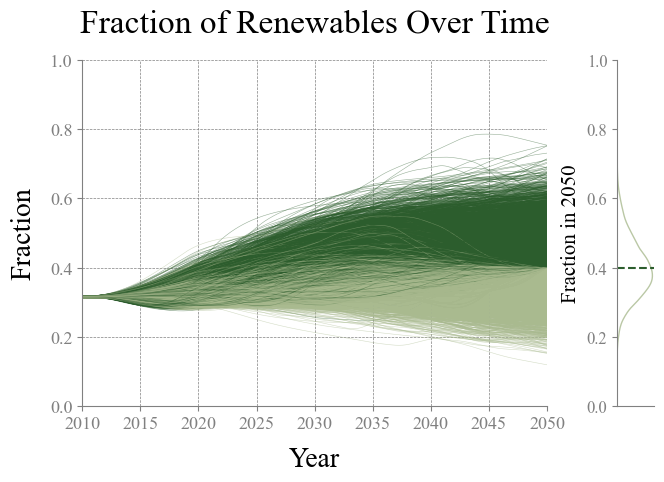


At threshold of 40.0% renewables by 2050:
   → 46.4% of cases exceed threshold (4637 of 10000)
   → 53.6% of cases fall below threshold (5363 of 10000)


In [3]:
plot_fraction_renewables(outcomes, threshold=0.4, save_path="renewables_over_time_0_6_threshold.pdf")

## Set Binary Threshold for y

In [4]:
threshold_value = 0.4  # for example
y = (y_continuous > threshold_value).astype(int)

## Change Categorical Variables to Dummy Variables

In [5]:
# Convert categorical variables to dummy variables, and clean column names
categorical_cols = [col for col in X.columns if str(X[col].dtype) == 'category']
X_dummy = pd.get_dummies(X, columns=categorical_cols, drop_first=True, dtype=float)
X_dummy = X_dummy.rename(columns=lambda col: " ".join(word.capitalize() for word in col.replace("_", " ").split()))

print(f"\nChanged categorical variables to dummy variables making the experiments Dataframe gain {X_dummy.shape[1]-X.shape[1]} columns.")


Changed categorical variables to dummy variables making the experiments Dataframe gain 22 columns.


In [6]:
# # Drop SWITCH columns, as they are not needed for the analysis
# switch_cols = [col for col in X_dummy.columns if col.startswith("SWITCH")]
# X_encoded = X_dummy.drop(columns=switch_cols)

## Applying HHCART(D)

In [7]:
# # Set tree parameters
# max_depth = 8
# min_purity = 0.95
# mass_min = 0.05
# 
# # Instantiate HHCART, build and save tree
# hh = HHCartD(X_dummy, y, min_purity=min_purity, mass_min=mass_min, max_depth=max_depth)
# hh.build_tree(f"hamarat_depth_{max_depth}_pur_{str(min_purity).replace('.', '_')}_mass_{str(mass_min).replace('.', '_')}")

In [8]:
# hh = load_model("hamarat_depth_8_pur_0_95_mass_0_05")
# hh.select(depth=3)
# hh.inspect()

In [9]:
# hh.plot_tree_structure(depth=6, save=True)

In [10]:
# hh.plot_metrics_vs_structure(save=True)

In [11]:
# hh.plot_metrics_vs_structure(save=True, x_axis="class1_leaf_count")

In [12]:
# hh.plot_tradeoff_path(save=True)

In [13]:
# hh.plot_tradeoff_path(save=True, color_by="class1_leaf_count")

In [14]:
# hh.plot_node_size_distribution(save=True)

## Applying Extra Trees Feature Scoring to Determine Features of Interest

In [15]:
p = X_dummy.shape[1]
feature_scores_class, model_class = get_ex_feature_scores(
    x=X_dummy,
    y=y,
    mode=RuleInductionType.CLASSIFICATION,
    nr_trees=250,
    max_features=p // 3,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=False,
    oob_score=False,
    random_state=42
)

### Print the Top Features

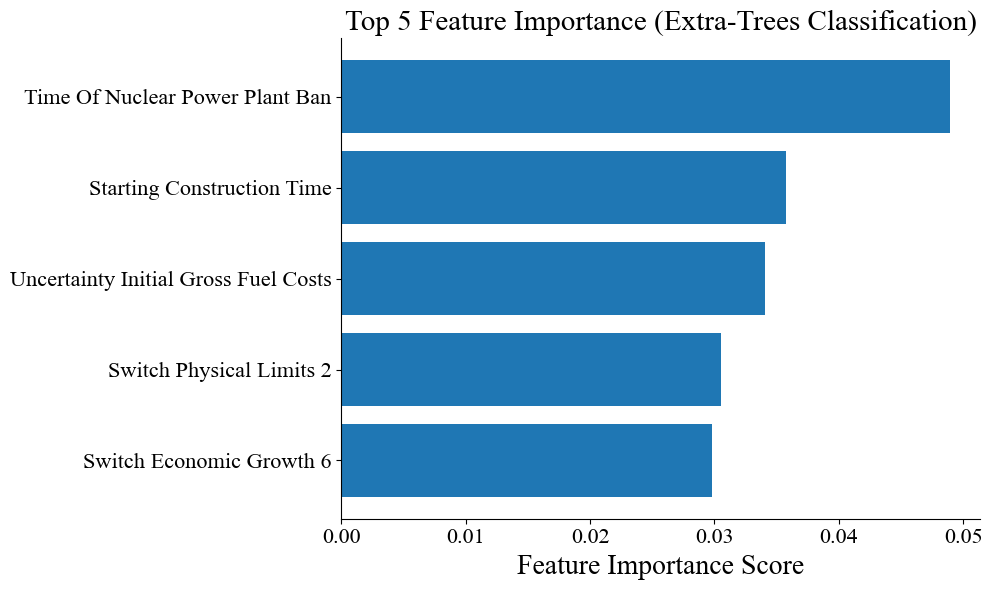

In [16]:
top_n = 5
top_features_class = feature_scores_class.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features_class.index, top_features_class.iloc[:, 0])  # assuming first column is the score
plt.xlabel('Feature Importance Score')
plt.title(f'Top {top_n} Feature Importance (Extra-Trees Classification)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Make Table for Latex

In [17]:
# Make a copy to avoid modifying the original DataFrame
df_for_latex = top_features_class.copy()

# Set a simple column name first
df_for_latex.columns = ["Importance"]

# Rename the column to include the LaTeX bold command
df_for_latex.rename(columns={"Importance": r"\textbf{Importance}"}, inplace=True)

def escape_latex(name):
    """Escapes special LaTeX characters for safe rendering."""
    if isinstance(name, str):
        return name.replace('_', r'\_').replace('%', r'\%').replace('$', r'\$')
    return name

# Apply escaping to the feature names (index), but WITHOUT bolding
df_for_latex.index = [escape_latex(feat) for feat in df_for_latex.index]

# Add a non-bold header for the feature column
df_for_latex.index.name = "Feature"

# Calculate and Append the Sum Row
sum_top5 = df_for_latex[r"\textbf{Importance}"].sum()

# Create a new DataFrame for the sum row (keeping this row bold)
sum_row_df = pd.DataFrame(
    data={r"\textbf{Importance}": [sum_top5]},
    index=["\\textbf{Sum of Top 5}"]
)
df_for_latex = pd.concat([df_for_latex, sum_row_df])

# 3. Convert the Prepared DataFrame to a LaTeX String
latex_table = df_for_latex.to_latex(
    index=True,
    float_format="%.3f",
    caption="Top 5 Feature Importance Scores (Extra-Trees Classifier). The values represent the relative contribution of each feature to impurity reduction across the ensemble. The sum of all feature importances equals 1.",
    label="tab:top5_features",
    escape=False,
    column_format="lc"
)

# Final Structural Adjustments to the String
# Add centering and extra vertical spacing for all rows
latex_table = latex_table.replace(
    r"\begin{table}",
    r"\begin{table}" + "\n\\centering" + "\n\\renewcommand{\\arraystretch}{1.5}"
)

# Add a horizontal line (\hline) to visually separate the sum from the features
sum_row_in_tex = f"\\textbf{{Sum of Top 5}} & {sum_top5:.3f}"
latex_table = latex_table.replace(sum_row_in_tex, "\\hline\n" + sum_row_in_tex)

# Save
output_dir = os.path.join("data", "feature_scoring")
output_file = os.path.join(output_dir, "feature_importance_top5.tex")
os.makedirs(output_dir, exist_ok=True)

with open(output_file, "w") as f:
    f.write(latex_table)

print(f"[INFO] LaTeX table saved to: {output_file}")

[INFO] LaTeX table saved to: data\feature_scoring\feature_importance_top5.tex


In [18]:
# Convert to list of top features
top_features_ordered = feature_scores_class.index.tolist()

## Loop Over Top-N Features and Build HHCART(D)

#### Minimum Purity = 0.95


[RUN] Building HHCartD with top 2 features: ['Time Of Nuclear Power Plant Ban', 'Starting Construction Time']
[INFO] Model title: hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  16%|█▌        | 81/511 [02:28<13:08,  1.83s/it] 


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta/tree_s

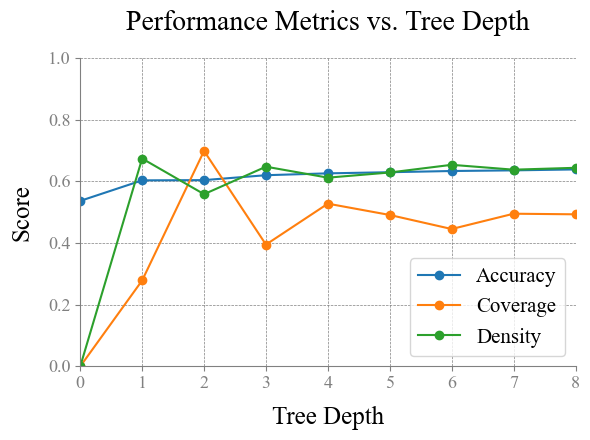

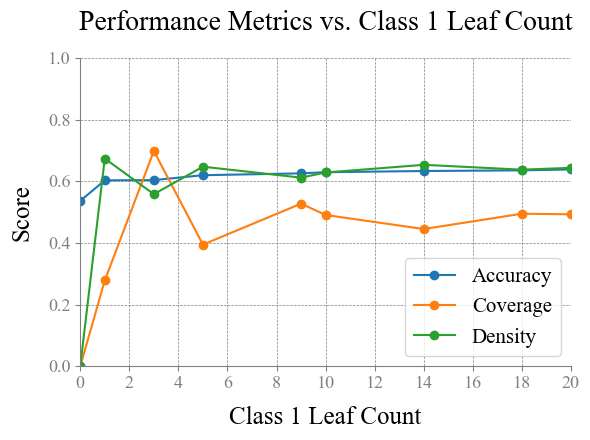

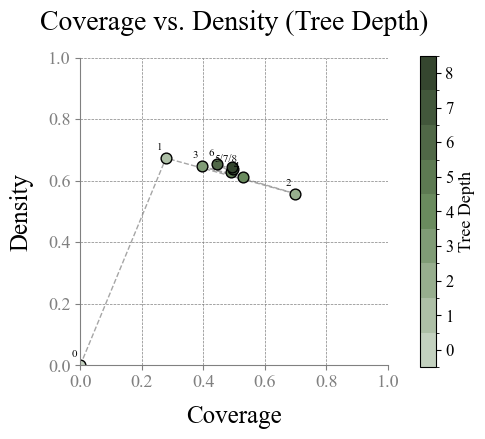

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta\coverage_density_path_class1_leaf_count.pdf


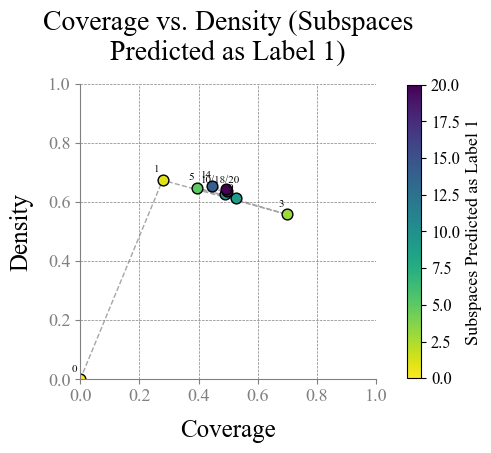

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top2f_dep_8_mass_0_05_pur_0_95_Tim_Sta\node_size_distribution.pdf

[DONE] Finished run with top 2 features.
[RESULT] Depths built: [0, 1, 2, 3, 4, 5, 6, 7, 8]

[RUN] Building HHCartD with top 3 features: ['Time Of Nuclear Power Plant Ban', 'Starting Construction Time', 'Uncertainty Initial Gross Fuel Costs']
[INFO] Model title: hhcart_top3f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  12%|█▏        | 59/511 [03:16<25:08,  3.34s/it]  


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_Ti

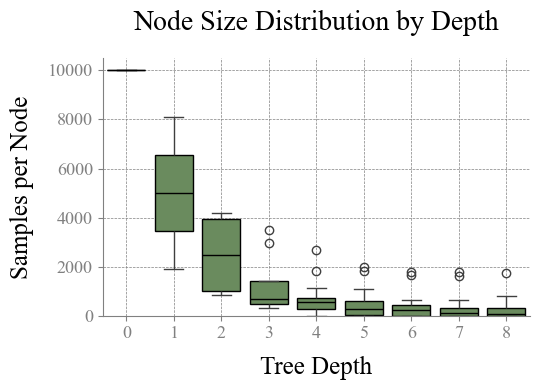

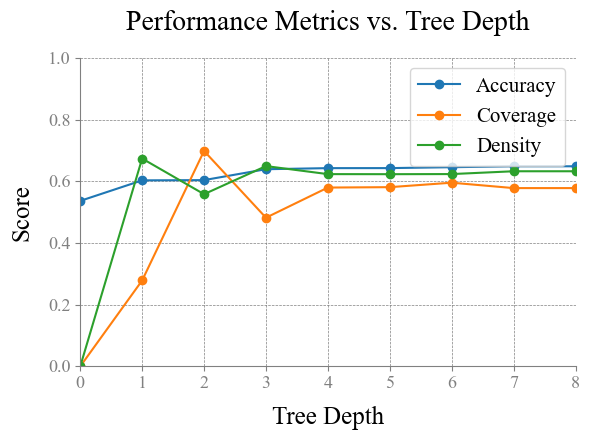

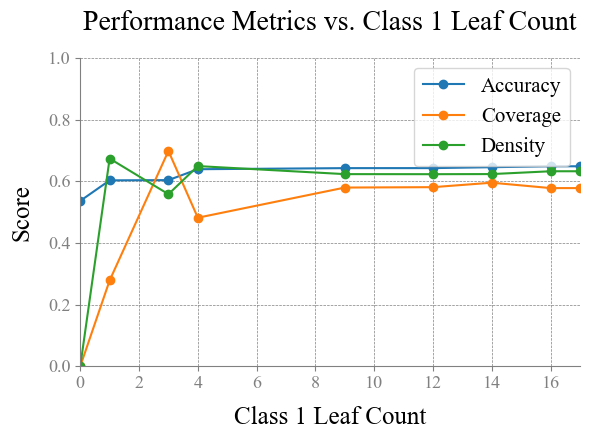

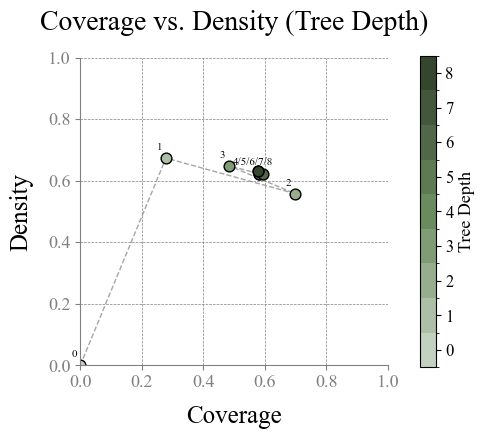

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc\coverage_density_path_class1_leaf_count.pdf


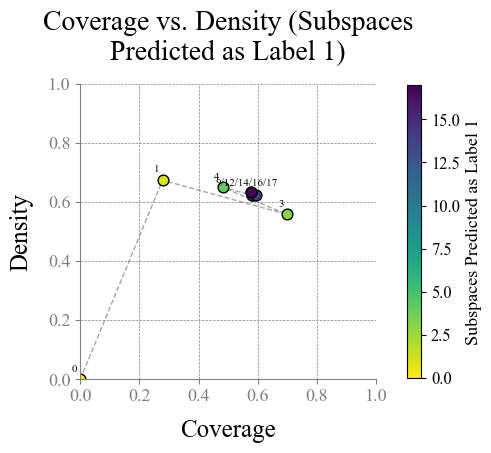

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top3f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc\node_size_distribution.pdf

[DONE] Finished run with top 3 features.
[RESULT] Depths built: [0, 1, 2, 3, 4, 5, 6, 7, 8]

[RUN] Building HHCartD with top 4 features: ['Time Of Nuclear Power Plant Ban', 'Starting Construction Time', 'Uncertainty Initial Gross Fuel Costs', 'Switch Physical Limits 2']
[INFO] Model title: hhcart_top4f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  17%|█▋        | 85/511 [03:18<16:34,  2.34s/it] 


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05

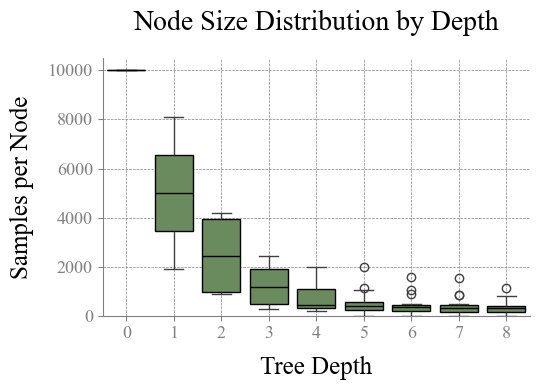

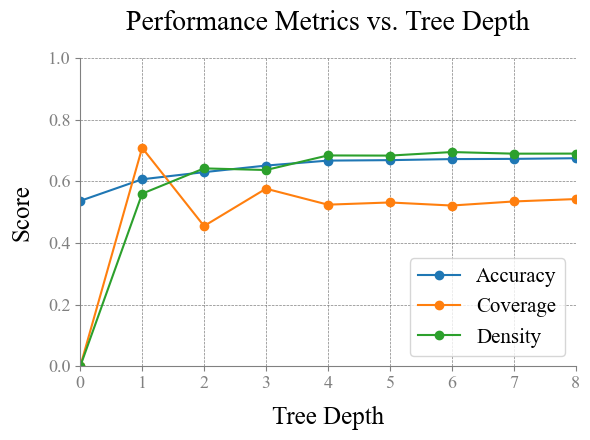

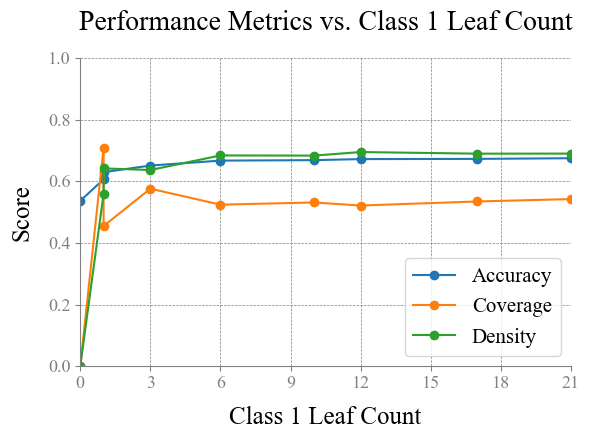

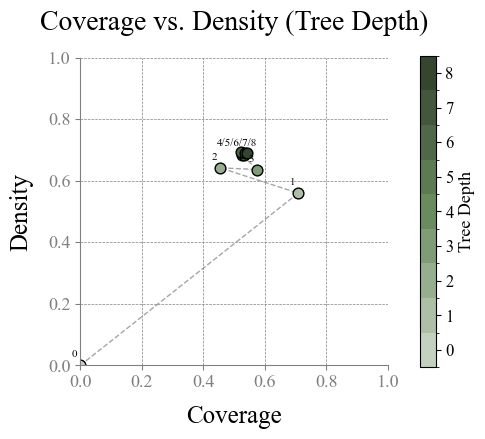

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi\coverage_density_path_class1_leaf_count.pdf


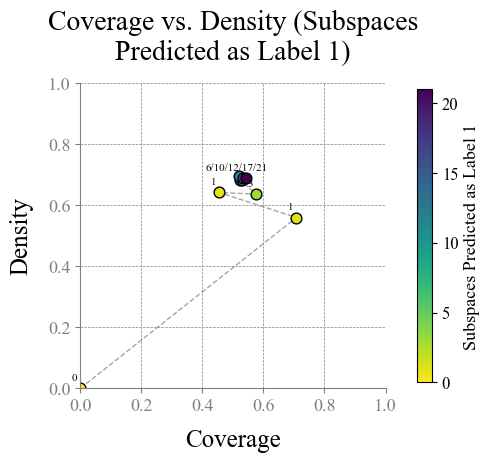

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top4f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi\node_size_distribution.pdf

[DONE] Finished run with top 4 features.
[RESULT] Depths built: [0, 1, 2, 3, 4, 5, 6, 7, 8]

[RUN] Building HHCartD with top 5 features: ['Time Of Nuclear Power Plant Ban', 'Starting Construction Time', 'Uncertainty Initial Gross Fuel Costs', 'Switch Physical Limits 2', 'Switch Economic Growth 6']
[INFO] Model title: hhcart_top5f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi_Swi
[INFO] Building HHCartD oblique decision tree...
[INFO] Max number of nodes allowed by maximum depth constraint: 511 (used as progress bar target; actual number of splits unknown in advance).


Building tree nodes:  13%|█▎        | 67/511 [03:45<24:52,  3.36s/it] 


[INFO] Pruning the full tree and evaluating metrics at each depth level; storing pruned trees and metrics...
[SAVED] HHCartD model saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi_Swi\model
[OK] Tree of depth 8 built and saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi_Swi
[OK] Selected tree at depth 0.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi_Swi/tree_structure_d0.pdf
[OK] Selected tree at depth 1.
[SAVE] Graphviz tree saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep

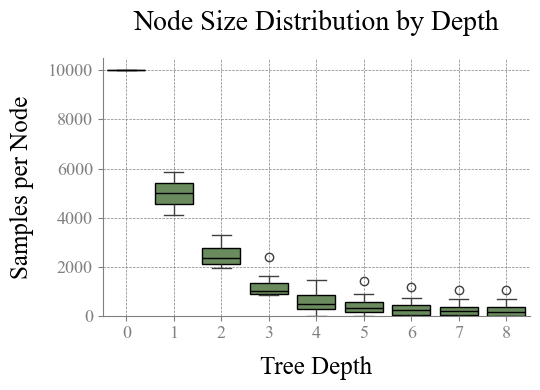

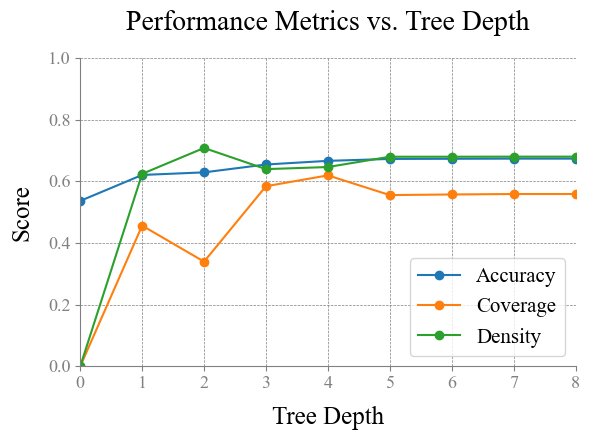

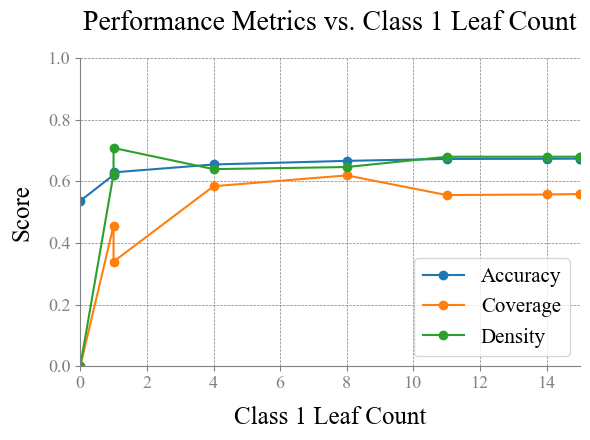

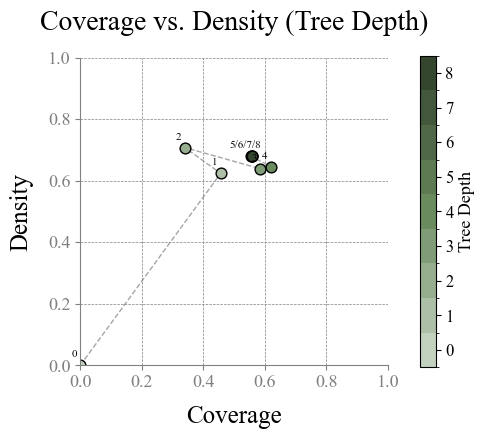

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi_Swi\coverage_density_path_class1_leaf_count.pdf


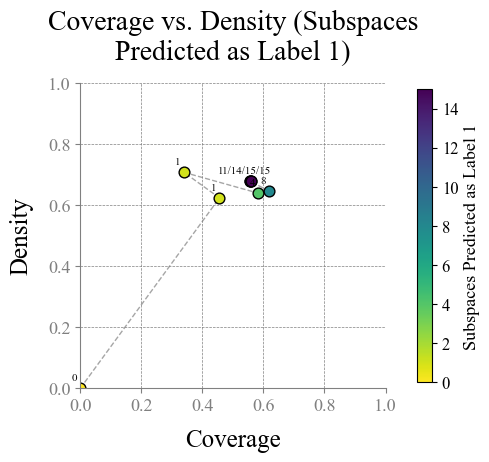

[SAVED] Figure saved to: C:\Users\jaspe\OneDrive\Desktop\Oblique-Decision-Tree-Algorithms-for-Scenario-Discovery\F_testing_on_policy_model\data\hhcart_top5f_dep_8_mass_0_05_pur_0_95_Tim_Sta_Unc_Swi_Swi\node_size_distribution.pdf

[DONE] Finished run with top 5 features.
[RESULT] Depths built: [0, 1, 2, 3, 4, 5, 6, 7, 8]


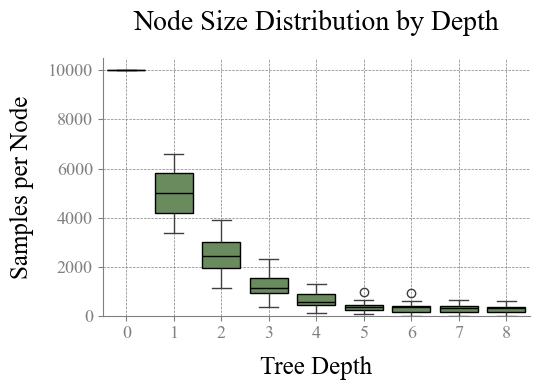

In [19]:
# Run HHCART(D) over top features
run_hhcart_over_top_features(
    X_full=X_dummy,
    y=y,
    feature_scores=feature_scores_class,
    top_n_range=(2,5),
    max_depth=8,
    mass_min=0.05,
    min_purity=0.95,
    debug=False
)